In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import os
import numpy as np
import xarray as xr

import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import matplotlib.colors as colors
import cmocean

import xpersist as xp
cache_dir = '/glade/p/cgd/oce/projects/cesm2-marbl/xpersist_cache/3d_fields'
if (os.path.isdir(cache_dir)):
    xp.settings['cache_dir'] = cache_dir
os.makedirs(cache_dir, exist_ok=True)

os.environ['CESMDATAROOT'] = '/glade/scratch/mclong/inputdata'
import pop_tools


import climo_utils as cu
import utils
import glodap 

/glade/work/mclong/miniconda3/envs/co2-hole/lib/python3.7/site-packages/numba/np/ufunc/parallel.py:363: NumbaWarning: The TBB threading layer requires TBB version 2019.5 or later i.e., TBB_INTERFACE_VERSION >= 11005. Found TBB_INTERFACE_VERSION = 6103. The TBB threading layer is disabled.
  warnings.warn(problem)


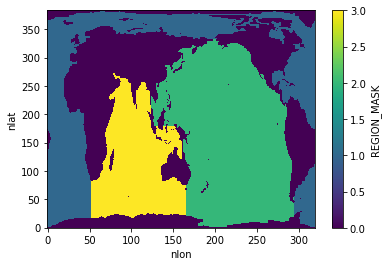

In [3]:
mask3d = utils.get_pop_region_mask_za(mask_type='3D')
basins = mask3d.region.rename({'region': 'basins'})
mask2d = utils.get_pop_region_mask_za(mask_type='2D')
mask2d.plot()

In [4]:
µmolkg_to_mmolm3 = 1026. * 1e-3 # µmol/kg --> mmol/m^3
µmolkg_to_mmolm3

1.026

In [5]:
fields_from = {
    'GLODAPv1': ['pCFC11', 'pCFC12', 'Del14C'],
    'GLODAPv2.2016b_MappedClimatologies': ['Cant', 'ALK'],
}

ds_list = []
for product_name, fields_list in fields_from.items():
    ds = glodap.open_glodap_pop_grid(product_name)[fields_list]
    ds_list_i = []
    for v in fields_list:
        ds_list_i.append(
            utils.zonal_mean_via_fortran(
                ds, var=v, 
                grid='POP_gx1v7', 
                region_mask=mask2d,
                replace_kmt=True,
            )
        )
        
    ds_list.append(xr.merge(ds_list_i))

ds_za = xr.merge(ds_list)

with xr.set_options(keep_attrs=True):
    for v in ['Cant', 'ALK']:
        ds_za[v] = ds_za[v] * µmolkg_to_mmolm3
        ds_za[v].attrs['units'] = 'mmol m$^{-3}$'

ds_za = ds_za.rename({k: f'{k}_obs' for k in ds_za.data_vars})
ds_za['basins'] = basins
ds_za

exists: /glade/work/mclong/adhoc-regridding/POP_gx1v7.nc
exists: /glade/work/mclong/adhoc-regridding/latlon_glodapv1.nc
source grid dims: (180, 360)
destination grid dims: (384, 320)
za ran successfully, writing netcdf output
za ran successfully, writing netcdf output
za ran successfully, writing netcdf output
exists: /glade/work/mclong/adhoc-regridding/POP_gx1v7.nc
exists: /glade/work/mclong/adhoc-regridding/latlon_glodapv2.nc
source grid dims: (180, 360)
destination grid dims: (384, 320)
za ran successfully, writing netcdf output
za ran successfully, writing netcdf output


<xarray.Dataset>
Dimensions:      (basins: 4, lat_t: 394, lat_t_edges: 395, z_t: 60)
Coordinates:
  * basins       (basins) <U14 'Global' 'Atlantic Ocean' ... 'Indian Ocean'
  * lat_t        (lat_t) float32 -79.22 -78.69 -78.15 ... 88.84 89.37 89.9
  * lat_t_edges  (lat_t_edges) float32 -79.49 -78.95 -78.42 ... 89.1 89.64 90.0
  * z_t          (z_t) float64 500.0 1.5e+03 2.5e+03 ... 5.125e+05 5.375e+05
Data variables:
    pCFC11_obs   (basins, z_t, lat_t) float64 ...
    pCFC12_obs   (basins, z_t, lat_t) float64 ...
    Del14C_obs   (basins, z_t, lat_t) float64 ...
    Cant_obs     (basins, z_t, lat_t) float64 nan nan 34.09 ... nan nan nan
    ALK_obs      (basins, z_t, lat_t) float64 nan nan 2.382e+03 ... nan nan nan

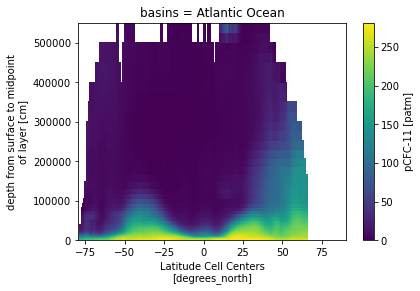

In [6]:
ds_za.pCFC11_obs.isel(basins=1).plot()

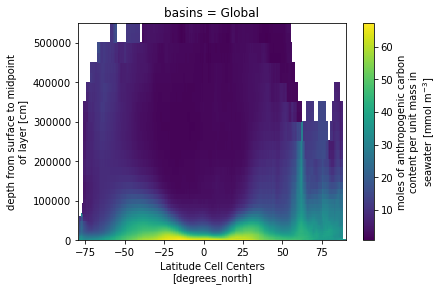

In [7]:
ds_za.Cant_obs.isel(basins=0).plot()

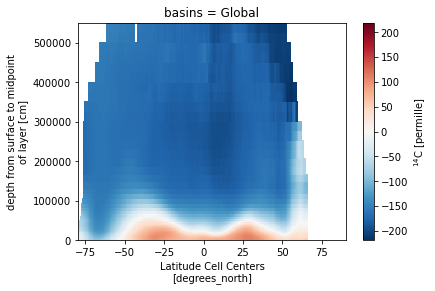

In [8]:
ds_za.Del14C_obs.isel(basins=0).plot()

In [9]:
cluster, client = utils.get_ClusterClient()
cluster.scale(12) #adapt(minimum_jobs=0, maximum_jobs=24)
client

/glade/work/mclong/miniconda3/envs/co2-hole/lib/python3.7/site-packages/distributed/dashboard/core.py:79: UserWarning: 
Port 8787 is already in use. 
Perhaps you already have a cluster running?
Hosting the diagnostics dashboard on a random port instead.
  warnings.warn("\n" + msg)


Client Scheduler: tcp://10.12.206.63:42975 Dashboard: https://jupyterhub.hpc.ucar.edu/stable/user/mclong/proxy/38862/status,Cluster Workers: 0 Cores: 0 Memory: 0 B


In [10]:
time_slice_glodapv2 = slice('2002-01-15', '2003-01-15')
time_slice_glodapv1 = slice('1990-01-15', '2001-01-15')

cesm_fields = dict(
    Cant=time_slice_glodapv2,
    ALK=time_slice_glodapv2,    
    pCFC11=time_slice_glodapv1,
    pCFC12=time_slice_glodapv1,    
    Del14C=time_slice_glodapv1,    
)

ds_cesm = {}
for variable, time_slice in cesm_fields.items():   
    xp_func = xp.persist_ds(cu.read_CESM_var, name=f'{variable}', trust_cache=True)    
    ds_cesm[variable] = xp_func(
        time_slice, 
        variable, 
        mean_dims=['member_id', 'time'], 
    )

assuming cache is correct
reading cached file: /glade/p/cgd/oce/projects/cesm2-marbl/xpersist_cache/3d_fields/Cant.nc
assuming cache is correct
reading cached file: /glade/p/cgd/oce/projects/cesm2-marbl/xpersist_cache/3d_fields/ALK.nc
assuming cache is correct
reading cached file: /glade/p/cgd/oce/projects/cesm2-marbl/xpersist_cache/3d_fields/pCFC11.nc
assuming cache is correct
reading cached file: /glade/p/cgd/oce/projects/cesm2-marbl/xpersist_cache/3d_fields/pCFC12.nc
assuming cache is correct
reading cached file: /glade/p/cgd/oce/projects/cesm2-marbl/xpersist_cache/3d_fields/Del14C.nc


In [11]:
client.close()
cluster.close()
del client
del cluster

In [12]:
ds_tmp = xr.merge([ds for ds in ds_cesm.values()])
ds_tmp = utils.zonal_mean_via_fortran(ds_tmp, 
                                      ','.join(ds_cesm.keys()), grid='POP_gx1v7', 
                                      region_mask=mask2d)
ds_tmp['z_t'] = ds_za.z_t
ds_za = xr.merge((ds_tmp, ds_za))

for v in ['pCFC11', 'pCFC12', 'Cant', 'Del14C']:
    ds_za[f'{v}_bias'] = ds_za[v] - ds_za[f'{v}_obs']
ds_za

za ran successfully, writing netcdf output


<xarray.Dataset>
Dimensions:      (basins: 4, lat_t: 394, lat_t_edges: 395, z_t: 60)
Coordinates:
  * basins       (basins) object 'Global' 'Atlantic Ocean' ... 'Indian Ocean'
  * lat_t        (lat_t) float32 -79.22 -78.69 -78.15 ... 88.84 89.37 89.9
  * lat_t_edges  (lat_t_edges) float32 -79.49 -78.95 -78.42 ... 89.1 89.64 90.0
  * z_t          (z_t) float64 500.0 1.5e+03 2.5e+03 ... 5.125e+05 5.375e+05
Data variables:
    Cant         (basins, z_t, lat_t) float32 ...
    ALK          (basins, z_t, lat_t) float32 ...
    pCFC11       (basins, z_t, lat_t) float32 ...
    pCFC12       (basins, z_t, lat_t) float32 ...
    Del14C       (basins, z_t, lat_t) float32 ...
    pCFC11_obs   (basins, z_t, lat_t) float64 nan nan 215.6 ... nan nan nan
    pCFC12_obs   (basins, z_t, lat_t) float64 nan nan 415.1 ... nan nan nan
    Del14C_obs   (basins, z_t, lat_t) float64 nan nan -23.11 ... nan nan nan
    Cant_obs     (basins, z_t, lat_t) float64 nan nan 34.09 ... nan nan nan
    ALK_obs      (basins, z_t, lat_t) float64 nan nan 2.382e+03 ... nan nan nan
    pCFC11_bias  (basins, z_t, lat_t) float64 nan nan -11.27 ... nan nan nan
    pCFC12_bias  (basins, z_t, lat_t) float64 nan nan -16.48 ... nan nan nan
    Cant_bias    (basins, z_t, lat_t) float64 nan nan -3.923 ... nan nan nan
    Del14C_bias  (basins, z_t, lat_t) float64 nan nan -16.61 ... nan nan nan

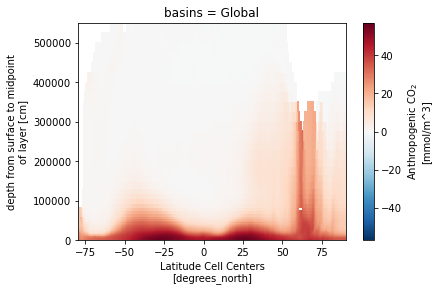

In [13]:
ds_za.Cant.isel(basins=0).plot()

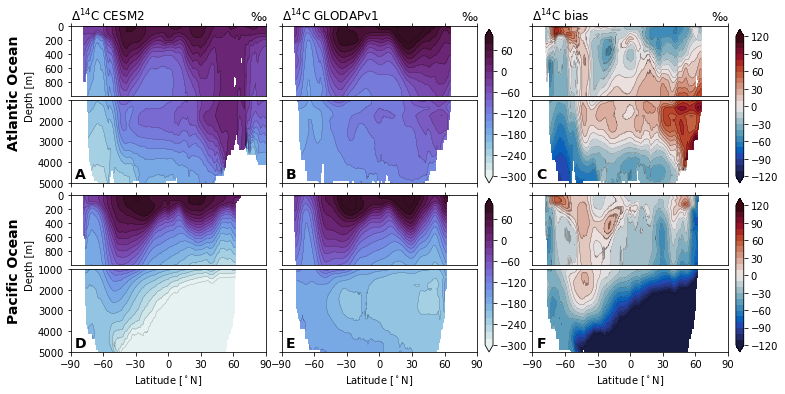

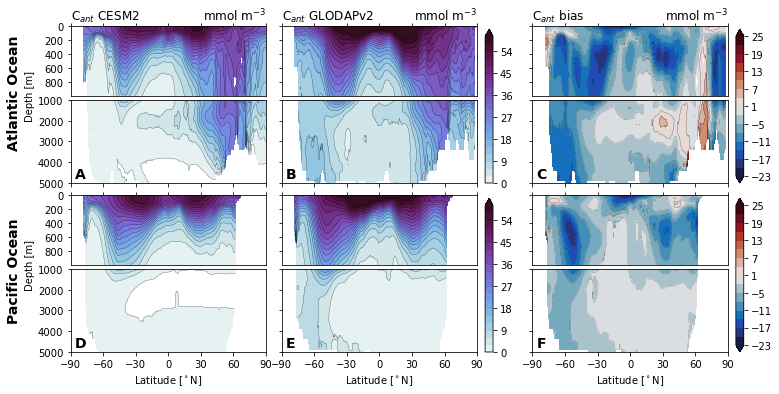

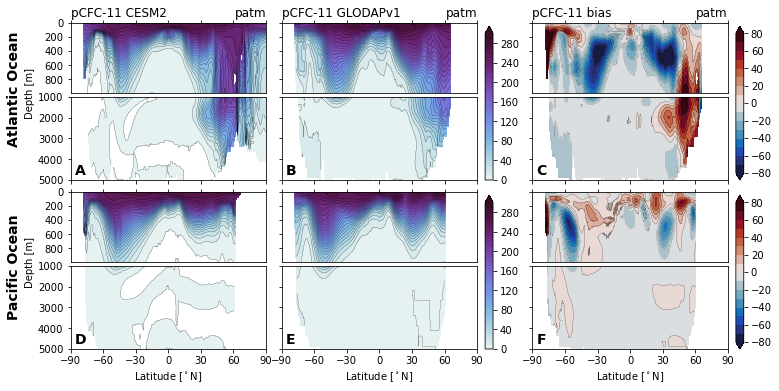

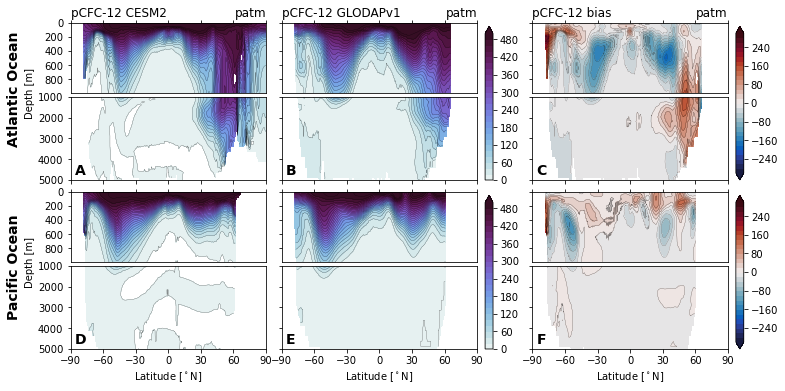

In [16]:
import plot

levels = dict(
    Cant=np.arange(0, 63, 3),
    pCFC11=np.arange(0, 310, 10),
    pCFC12=np.arange(0, 520, 20),
    Del14C=np.arange(-300, 120, 20),    
    ALK=np.arange(1800, 2600, 200),        
)

    
levels_bias = dict(
    Cant=np.arange(-23, 26, 3),
    pCFC11=np.arange(-80, 90, 10),    
    pCFC12=np.arange(-300, 320, 20),        
    Del14C=np.arange(-120, 130, 10),        
)  

for field in ['Del14C', 'Cant', 'pCFC11', 'pCFC12',]:
    glodap_str = 'GLODAPv2' if field == 'Cant' else 'GLODAPv1'
    plot.za_obs_comparison(
        ds_za, 
        field=field, 
        levels=levels[field], 
        levels_bias=levels_bias[field],
        col_name=['CESM2', glodap_str, 'bias'],
    )
    utils.savefig(f'za-obs-comparison-{field}.pdf')